# Basic depth map processing

In [1]:
import cv2
from pathlib import Path
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, f1_score

### Visualization

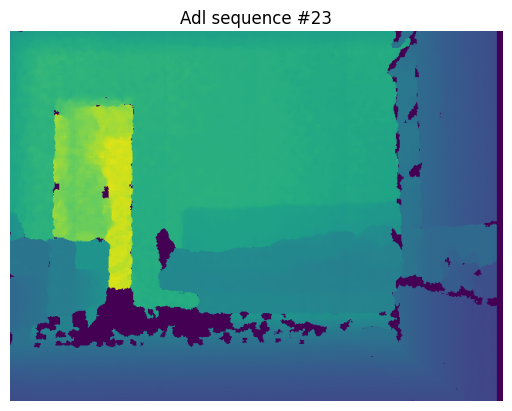

In [2]:
label = 'adl' # fall, adl
sequence_number = random.randint(0, 40 if label == 'adl' else 30) + 1
selected_video = Path(f'../datasets/{label}/sequence-{sequence_number:02}')

frames = sorted(selected_video.glob('*.png'))

for frame_path in frames:

    gray = cv2.imread(str(frame_path), cv2.IMREAD_GRAYSCALE)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    viridis = cv2.applyColorMap(gray, cv2.COLORMAP_VIRIDIS)
    viridis = cv2.cvtColor(viridis, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(viridis)

    clear_output(wait=True)
    plt.imshow(img)
    plt.title(f'{label.capitalize()} sequence #{sequence_number}')
    plt.axis("off")
    plt.show()

# Dataset

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.sequences = []
        self.transform = transform
        self.number_of_frames = 256

        classes = ['adl', 'fall']
        for label_idx, cls in enumerate(classes):
            cls_path = Path(root_dir) / cls
            for seq_folder in cls_path.iterdir():
                if seq_folder.is_dir():
                    frames = sorted(seq_folder.glob("*.png"))
                    imgs = []
                    for f in frames:
                        gray = cv2.imread(str(f), cv2.IMREAD_GRAYSCALE)
                        gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
                        viridis = cv2.applyColorMap(gray, cv2.COLORMAP_VIRIDIS)
                        viridis = cv2.cvtColor(viridis, cv2.COLOR_BGR2RGB)
                        img = Image.fromarray(viridis)
                        if self.transform:
                            img = self.transform(img)
                        imgs.append(img)
                    self.sequences.append((imgs, label_idx))
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        imgs, label = self.sequences[idx] 
        T = len(imgs)

        if T >= self.number_of_frames:
            imgs = imgs[-self.number_of_frames:]
        else:
            pad = self.number_of_frames - T
            first = imgs[0]
            imgs = [first for _ in range(pad)] + imgs

        video_tensor = torch.stack(imgs)  # (T, C, H, W)
        return video_tensor, label



In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
root_dir = Path('../datasets')

dataset = VideoDataset(root_dir, transform)

### Model

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, cnn_model='resnet18', hidden_size=256, num_classes=2, pretrained=True):
        super(CNN_LSTM, self).__init__()
        
        self.cnn = models.resnet18(pretrained=pretrained)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # output: (B, 512, 1, 1)

        for param in self.cnn.parameters():
            param.requires_grad = False

        self.feature_dim = 512
        self.lstm = nn.LSTM(input_size=self.feature_dim, hidden_size=hidden_size, 
                          num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        """
        x: (B, T, C, H, W)
        B = batch_size
        T = num_frames
        C = channels
        H = height
        W = width
        """
        B, T, C, H, W = x.size()

        cnn_features = []
        for t in range(T):
            frame = x[:, t, :, :, :]        # (B, C, H, W)
            feat = self.cnn(frame)          # (B, 512, 1, 1)
            feat = feat.view(B, -1)         # (B, 512)
            cnn_features.append(feat)
        

        cnn_features = torch.stack(cnn_features, dim=1)
        
        # LSTM
        lstm_out, _ = self.lstm(cnn_features) 

        # Last timestep: (B, hidden_size)
        last_time_step = lstm_out[:, -1, :] 

        out = self.fc(last_time_step) # (B, num_classes)
        return out

In [ ]:
model = CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)

# summary(model, input_size=(4, 256, 3, 224, 224), device=device)

In [ ]:
from sklearn.model_selection import train_test_split


num_epochs = 10
batch_size = 4

indices = list(range(len(dataset)))
labels = [dataset[i][1] for i in indices]
train_idx, val_idx = train_test_split(indices, test_size=0.15, stratify=labels, random_state=42)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)


checkpoint_dir = Path('../models')
checkpoint_dir.mkdir(exist_ok=True, parents=True)
best_val_loss = 1e10

for epoch in range(num_epochs):
    # ===================== TRAIN =====================
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for i, (videos, labels) in enumerate(train_loader):
        videos = videos.to(device)   # (B, T, C, H, W)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)      # (B, num_classes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * videos.size(0)

        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_dataset)
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] TRAIN -> Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # ===================== VALIDATION =====================
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for videos, labels in val_loader:
            videos = videos.to(device)
            labels = labels.to(device)

            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * videos.size(0)

            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_dataset)
    val_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] VAL   -> Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # ===================== CHECKPOINT =====================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = checkpoint_dir / f'best_model_viridis.pt'
        torch.save(model.state_dict(), checkpoint_path)
        print(f"\tSaved")


In [ ]:
best_model_path = checkpoint_dir / 'best_model_viridis.pt'
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for videos, labels in DataLoader(dataset, batch_size=4, shuffle=False):
        videos = videos.to(device)
        labels = labels.to(device)

        outputs = model(videos)               # (B, num_classes)
        _, predicted = torch.max(outputs, 1)  # (B,)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='binary')
rec = recall_score(all_labels, all_preds, average='binary')
rec = f1_score(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall: {rec*100:.2f}%")
print(f"F1: {rec*100:.2f}%")

ConfusionMatrixDisplay(cm).plot()